In [1]:
# Cell 1: Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, adjusted_rand_score, silhouette_score
import skfuzzy as fuzz
from scipy.optimize import linear_sum_assignment
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install scikit-fuzzy

In [3]:
# Cell 2: FCM Euclidean (sử dụng skfuzzy)
class FCMEuclidean:
    def __init__(self, n_clusters=8, m=2, max_iter=1000, error=0.005, random_state=42):
        """FCM với khoảng cách Euclidean"""
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.error = error
        self.random_state = random_state
        self.centroids = None
        self.u = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def fit(self, X, y):
        """Huấn luyện mô hình FCM Euclidean"""
        print("FCM Euclidean - Bắt đầu chuẩn hóa dữ liệu...")
        X_scaled = self.scaler.fit_transform(X)
        y_encoded = self.label_encoder.fit_transform(y)
        
        print(f"FCM Euclidean - Đã encode {len(self.label_encoder.classes_)} classes")
        
        data_for_fcm = X_scaled.T
        print(f"FCM Euclidean - Shape dữ liệu: {data_for_fcm.shape}")
        
        print("FCM Euclidean - Bắt đầu clustering...")
        start_time = time.time()
        
        np.random.seed(self.random_state)
        self.centroids, self.u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data_for_fcm, 
            self.n_clusters, 
            self.m, 
            error=self.error, 
            maxiter=self.max_iter,
            init=None
        )
        
        self.training_time = time.time() - start_time
        print(f"FCM Euclidean - Hoàn thành! Thời gian: {self.training_time:.2f}s")
        return self
    
    def predict(self, X_test):
        """Dự đoán cụm cho dữ liệu test"""
        X_test_scaled = self.scaler.transform(X_test)
        data_for_prediction = X_test_scaled.T
        
        u_test, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
            data_for_prediction,
            self.centroids,
            self.m,
            error=self.error,
            maxiter=self.max_iter
        )
        
        return np.argmax(u_test, axis=0)

In [4]:
# Cell 3: FCM Canberra (đã sửa lỗi)
class FCMCanberra:
    """
    Fuzzy-C-Means với khoảng cách Canberra – bản vector-hoá nhanh & ổn định.
    """
    def __init__(self, n_clusters=8, m=2, max_iter=150, tol=1e-4, random_state=42):
        self.c = n_clusters
        self.n_clusters = n_clusters  # để tương thích với interface
        self.m = m
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.u = None
        self.scaler = RobustScaler()
        self.label_encoder = LabelEncoder()
        np.random.seed(random_state)

    @staticmethod
    def _canberra_pairwise(A, B, eps=1e-10):
        """
        Trả về ma trận khoảng cách Canberra |A|×|B|.
        Vector-hoá: không vòng lặp Python.
        """
        num   = np.abs(A[:, None, :] - B[None, :, :])      # (|A|,|B|,P)
        denom = np.abs(A[:, None, :]) + np.abs(B[None, :, :]) + eps
        return np.sum(num / denom, axis=-1)                # (|A|,|B|)

    def _update_centroids(self, X, U_m):
        """Cập nhật centroids theo công thức vector-hoá."""
        return (U_m.T @ X) / U_m.sum(axis=0)[:, None]      # (C,P)

    def fit(self, X, y):
        """
        Huấn luyện mô hình trên dữ liệu X.
        """
        print("FCM Canberra - Bắt đầu chuẩn hóa dữ liệu...")
        X_scaled = self.scaler.fit_transform(X)
        y_encoded = self.label_encoder.fit_transform(y)
        
        print(f"FCM Canberra - Đã encode {len(self.label_encoder.classes_)} classes")
        
        N, P = X_scaled.shape
        print(f"FCM Canberra - Shape dữ liệu: {X_scaled.shape}")
        
        print("FCM Canberra - Bắt đầu clustering...")
        start_time = time.time()

        # 1️⃣ Khởi tạo ngẫu nhiên ma trận membership (N,C)
        np.random.seed(self.random_state)
        U = np.random.rand(N, self.c)
        U /= U.sum(axis=1, keepdims=True)      # chuẩn hoá từng hàng

        # Khởi tạo centroids cho vòng lặp đầu tiên
        prev_centroids = None

        # Lặp FCM
        for itr in range(self.max_iter):
            U_m      = U ** self.m                             # (N,C)
            cent_new = self._update_centroids(X_scaled, U_m)   # (C,P)

            # 2️⃣ Tính khoảng cách cho **tất cả** điểm & centroids một lần
            D = self._canberra_pairwise(X_scaled, cent_new)    # (N,C)

            # 3️⃣ Cập nhật ma trận membership U
            zero_mask = (D == 0)                               # (N,C)
            if np.any(zero_mask):   # xử lý trường hợp điểm trùng centroid
                U[...] = zero_mask / zero_mask.sum(axis=1, keepdims=True)
            else:
                # ratio_{ikj} = (d_{ik}/d_{ij})^{2/(m-1)}
                power = 2.0 / (self.m - 1)
                ratio = (D[:, :, None] / D[:, None, :]) ** power   # (N,C,C)
                U = 1.0 / ratio.sum(axis=2)                       # (N,C)

            # 4️⃣ Kiểm tra hội tụ (đã sửa lỗi)
            if prev_centroids is not None and np.allclose(cent_new, prev_centroids, atol=self.tol):
                print(f"FCM Canberra - ✓ Hội tụ sau {itr+1} vòng lặp.")
                break

            prev_centroids = cent_new.copy()  # Lưu centroid hiện tại để so sánh lần sau

        # Lưu kết quả cuối
        self.centroids = cent_new
        self.u = U
        self.training_time = time.time() - start_time
        print(f"FCM Canberra - Hoàn thành! Thời gian: {self.training_time:.2f}s")
        return self

    def predict(self, X_test):
        """Trả về label cứng (argmax U) cho mỗi điểm X."""
        if self.centroids is None:
            raise RuntimeError("Bạn phải gọi fit trước.")
        
        X_test_scaled = self.scaler.transform(X_test)
        D = self._canberra_pairwise(X_test_scaled, self.centroids)
        
        zero_mask = (D == 0)
        if np.any(zero_mask):
            U = zero_mask / zero_mask.sum(axis=1, keepdims=True)
        else:
            power = 2.0 / (self.m - 1)
            ratio = (D[:, :, None] / D[:, None, :]) ** power
            U = 1.0 / ratio.sum(axis=2)
        
        return U.argmax(axis=1)

In [5]:
import numpy as np, time
from sklearn.preprocessing import StandardScaler, LabelEncoder

class FCMCanberra:
    """
    Fuzzy-C-Means với khoảng cách Canberra – bản vector-hoá, 
    vẫn giữ đúng interface gốc của bạn.
    """
    def __init__(self, n_clusters=8, m=2, max_iter=150,
                 tol=1e-4, random_state=42):
        self.c  = n_clusters              # số cụm
        self.m  = m                       # fuzziness
        self.max_iter, self.tol = max_iter, tol
        self.random_state = random_state
        np.random.seed(random_state)

        # giữ nguyên scaler & encoder để tương thích
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

        # sẽ khởi tạo khi fit
        self.centroids = None
        self.u         = None 

    # ---------- tiện ích -------------------------------------------------
    @staticmethod
    def _canberra_pairwise(A, B, eps=1e-10):
        num   = np.abs(A[:, None, :] - B[None, :, :])
        denom = np.abs(A[:, None, :]) + np.abs(B[None, :, :]) + eps
        return np.sum(num / denom, axis=-1)

    @staticmethod
    def _update_centroids(X, U_m):
        return (U_m.T @ X) / U_m.sum(axis=0)[:, None]
    # --------------------------------------------------------------------

    def fit(self, X, y=None):
        """
        X : ndarray (N,P) – dữ liệu cần phân cụm
        y : ndarray (N,)  – label gốc (không dùng trong thuật toán,
                             chỉ lưu lại để đánh giá nếu muốn)
        """
        print("FCM Canberra ▶ Chuẩn hoá dữ liệu…")
        X_scaled = self.scaler.fit_transform(X)

        if y is not None:
            y_encoded = self.label_encoder.fit_transform(y)  # giữ nguyên interface
            self.y_true_ = y_encoded      # lưu lại để bạn tuỳ dùng sau

        N, _ = X_scaled.shape
        rng = np.random.RandomState(self.random_state)
        U = rng.rand(N, self.c)
        U /= U.sum(axis=1, keepdims=True)

        prev_centroids = None
        tic = time.time()
        for itr in range(self.max_iter):
            U_m = U ** self.m
            cent_new = self._update_centroids(X_scaled, U_m)
            D = self._canberra_pairwise(X_scaled, cent_new)

            # cập nhật U
            zero = D == 0
            if zero.any():
                U = zero / zero.sum(axis=1, keepdims=True)
            else:
                p = 2.0 / (self.m - 1)
                U = 1.0 / np.sum((D[:, :, None] / D[:, None, :]) ** p, axis=2)

            # hội tụ
            if prev_centroids is not None and np.allclose(cent_new, prev_centroids, atol=self.tol):
                print(f"FCM Canberra ▶ Hội tụ sau {itr+1} vòng lặp.")
                break
            prev_centroids = cent_new.copy()

        self.centroids = cent_new
        self.u = U
        self.training_time = time.time() - tic
        print(f"FCM Canberra ▶ Hoàn thành ({self.training_time:.2f}s).")
        return self

    def predict(self, X_test):
        if self.centroids is None:
            raise RuntimeError("Hãy gọi fit() trước khi predict().")
        X_test_scaled = self.scaler.transform(X_test)
        D = self._canberra_pairwise(X_test_scaled, self.centroids)
        zero = D == 0
        if zero.any():
            U = zero / zero.sum(axis=1, keepdims=True)
        else:
            p = 2.0 / (self.m - 1)
            U = 1.0 / np.sum((D[:, :, None] / D[:, None, :]) ** p, axis=2)
        return U.argmax(axis=1)            # nhãn cứng


In [6]:
# Cell 4: Module đánh giá chung
class FCMComparator:
    def __init__(self):
        pass
    
    def _calculate_accuracy(self, predicted_clusters, true_labels):
        """Tính accuracy bằng Hungarian algorithm"""
        n_clusters = len(np.unique(predicted_clusters))
        n_classes = len(np.unique(true_labels))
        
        cost_matrix = np.zeros((n_clusters, n_classes))
        
        for i in range(n_clusters):
            for j in range(n_classes):
                cost_matrix[i, j] = -np.sum((predicted_clusters == i) & (true_labels == j))
        
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        
        total_correct = 0
        for i, j in zip(row_indices, col_indices):
            total_correct += -cost_matrix[i, j]
        
        accuracy = total_correct / len(true_labels)
        return accuracy
    
    def evaluate_model(self, model, X_test, y_test):
        """Đánh giá một mô hình"""
        start_time = time.time()
        predicted_clusters = model.predict(X_test)
        prediction_time = time.time() - start_time
        
        y_test_encoded = model.label_encoder.transform(y_test)
        
        accuracy = self._calculate_accuracy(predicted_clusters, y_test_encoded)
        ari = adjusted_rand_score(y_test_encoded, predicted_clusters)
        
        X_test_scaled = model.scaler.transform(X_test)
        silhouette = silhouette_score(X_test_scaled, predicted_clusters)
        
        return {
            'accuracy': accuracy,
            'adjusted_rand_index': ari,
            'silhouette_score': silhouette,
            'training_time': model.training_time,
            'prediction_time': prediction_time,
            'predicted_clusters': predicted_clusters,
            'true_labels_encoded': y_test_encoded
        }
    
    def compare_models(self, models_dict, X_test, y_test):
        """So sánh nhiều mô hình"""
        results = {}
        
        for name, model in models_dict.items():
            print(f"\n=== ĐÁNH GIÁ {name} ===")
            results[name] = self.evaluate_model(model, X_test, y_test)
            
        return results

In [7]:
# Cell 5: Đọc và làm sạch dữ liệu
df = pd.read_csv('file_data_1.csv')
print(f"Shape ban đầu: {df.shape}")
print(f"Số lượng nhãn unique: {df['label'].nunique()}")
print(f"Các nhãn: {df['label'].unique()}")

# =============================================================================
# BƯỚC 1: KIỂM TRA THÔNG TIN CƠ BẢN
# =============================================================================
print("\n" + "="*50)
print("THÔNG TIN CƠ BẢN VỀ DỮ LIỆU")
print("="*50)
print(f"Kiểu dữ liệu các cột:")
print(df.dtypes.value_counts())
print(f"\nSố lượng missing values:")
print(df.isnull().sum().sum())

# =============================================================================
# BƯỚC 2: XỬ LÝ MISSING VALUES
# =============================================================================
print("\n" + "="*50)
print("XỬ LÝ MISSING VALUES")
print("="*50)

# Kiểm tra missing values chi tiết
missing_info = df.isnull().sum()
missing_cols = missing_info[missing_info > 0]

if len(missing_cols) > 0:
    print("Các cột có missing values:")
    for col, count in missing_cols.items():
        pct = (count / len(df)) * 100
        print(f"  {col}: {count} ({pct:.2f}%)")
    
    # Xử lý missing values
    # Với numeric columns: fill bằng median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = numeric_cols.drop('label', errors='ignore')  # Loại bỏ label nếu có
    
    for col in numeric_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"  Đã fill {col} bằng median: {median_val}")
else:
    print("✓ Không có missing values")

# =============================================================================
# BƯỚC 3: XỬ LÝ DUPLICATES
# =============================================================================
print("\n" + "="*50)
print("XỬ LÝ DUPLICATES")
print("="*50)

duplicates = df.duplicated().sum()
print(f"Số dòng duplicate: {duplicates}")

if duplicates > 0:
    df_clean = df.drop_duplicates()
    print(f"✓ Đã xóa {duplicates} dòng duplicate")
    print(f"Shape sau khi xóa duplicates: {df_clean.shape}")
else:
    df_clean = df.copy()
    print("✓ Không có duplicates")

# =============================================================================
# BƯỚC 4: XỬ LÝ OUTLIERS (CHỈ HIỂN THỊ, KHÔNG XÓA)
# =============================================================================
print("\n" + "="*50)
print("KIỂM TRA OUTLIERS")
print("="*50)

# Lấy các cột numeric (trừ label)
numeric_features = df_clean.select_dtypes(include=[np.number]).columns
if 'label' in numeric_features:
    numeric_features = numeric_features.drop('label')

print(f"Kiểm tra outliers cho {len(numeric_features)} features numeric...")

outlier_counts = {}
for col in numeric_features[:5]:  # Chỉ kiểm tra 5 cột đầu để không quá dài
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    outlier_counts[col] = len(outliers)
    
    if len(outliers) > 0:
        pct = (len(outliers) / len(df_clean)) * 100
        print(f"  {col}: {len(outliers)} outliers ({pct:.2f}%)")

# =============================================================================
# BƯỚC 5: KIỂM TRA PHÂN PHỐI LABELS
# =============================================================================
print("\n" + "="*50)
print("PHÂN PHỐI LABELS")
print("="*50)

label_counts = df_clean['label'].value_counts()
print("Số lượng samples cho mỗi class:")
for label, count in label_counts.items():
    pct = (count / len(df_clean)) * 100
    print(f"  {label}: {count} ({pct:.2f}%)")

# Kiểm tra class imbalance
max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count
print(f"\nTỷ lệ imbalance: {imbalance_ratio:.2f}")

if imbalance_ratio > 10:
    print("⚠️  Dữ liệu có class imbalance nghiêm trọng!")
elif imbalance_ratio > 3:
    print("⚠️  Dữ liệu có class imbalance vừa phải")
else:
    print("✓ Dữ liệu khá cân bằng")

# =============================================================================
# BƯỚC 6: XỬ LÝ FEATURES KHÔNG HỢP LỆ
# =============================================================================
print("\n" + "="*50)
print("XỬ LÝ FEATURES KHÔNG HỢP LỆ")
print("="*50)

# Xóa các cột có variance = 0 (constant features)
variance_check = df_clean.select_dtypes(include=[np.number]).var()
if 'label' in variance_check.index:
    variance_check = variance_check.drop('label')

zero_var_cols = variance_check[variance_check == 0].index.tolist()
if zero_var_cols:
    print(f"Các features có variance = 0: {zero_var_cols}")
    df_clean = df_clean.drop(columns=zero_var_cols)
    print(f"✓ Đã xóa {len(zero_var_cols)} features constant")
else:
    print("✓ Không có features constant")

# Xóa các cột có quá nhiều giá trị 0
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
if 'label' in numeric_cols:
    numeric_cols = numeric_cols.drop('label')

zero_heavy_cols = []
for col in numeric_cols:
    zero_pct = (df_clean[col] == 0).sum() / len(df_clean)
    if zero_pct > 0.95:  # Nếu >95% là 0
        zero_heavy_cols.append(col)

if zero_heavy_cols:
    print(f"Các features có >95% giá trị 0: {zero_heavy_cols}")
    print(f"⚠️  Cân nhắc xóa các features này")
else:
    print("✓ Không có features với quá nhiều giá trị 0")

# =============================================================================
# KẾT QUẢ CUỐI CÙNG
# =============================================================================
print("\n" + "="*60)
print("KẾT QUẢ SAU KHI CLEANING")
print("="*60)
print(f"Shape cuối cùng: {df_clean.shape}")
print(f"Số features: {df_clean.shape[1] - 1}")  # Trừ cột label
print(f"Số samples: {df_clean.shape[0]}")
print(f"Số classes: {df_clean['label'].nunique()}")

# Tách features và labels sau khi cleaning
X = df_clean.drop('label', axis=1)
y = df_clean['label']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X data types: {X.dtypes.value_counts().to_dict()}")

# Kiểm tra có còn NaN không
if X.isnull().any().any():
    print("⚠️  X vẫn còn NaN values!")
else:
    print("✓ X không có NaN values")

print("\n✅ DATA CLEANING HOÀN TẤT!")

Shape ban đầu: (466866, 47)
Số lượng nhãn unique: 8
Các nhãn: ['Benign' 'DDoS' 'DoS' 'Mirai' 'Spoofing' 'Recon' 'Web-Based'
 'Brute Force']

THÔNG TIN CƠ BẢN VỀ DỮ LIỆU
Kiểu dữ liệu các cột:
float64    46
object      1
Name: count, dtype: int64

Số lượng missing values:
0

XỬ LÝ MISSING VALUES
✓ Không có missing values

XỬ LÝ DUPLICATES
Số dòng duplicate: 0
✓ Không có duplicates

KIỂM TRA OUTLIERS
Kiểm tra outliers cho 46 features numeric...
  flow_duration: 87903 outliers (18.83%)
  Header_Length: 114684 outliers (24.56%)
  Protocol Type: 17100 outliers (3.66%)
  Duration: 124138 outliers (26.59%)
  Rate: 102779 outliers (22.01%)

PHÂN PHỐI LABELS
Số lượng samples cho mỗi class:
  DDoS: 339846 (72.79%)
  DoS: 80907 (17.33%)
  Mirai: 26341 (5.64%)
  Benign: 10982 (2.35%)
  Spoofing: 4865 (1.04%)
  Recon: 3546 (0.76%)
  Web-Based: 248 (0.05%)
  Brute Force: 131 (0.03%)

Tỷ lệ imbalance: 2594.24
⚠️  Dữ liệu có class imbalance nghiêm trọng!

XỬ LÝ FEATURES KHÔNG HỢP LỆ
Các features có var

In [8]:
# # Cell 5: Đọc và chuẩn bị dữ liệu
# df = pd.read_csv('file_data_1.csv')
# print(f"Shape của dữ liệu: {df.shape}")
# print(f"Số lượng nhãn unique: {df['label'].nunique()}")
# print(f"Các nhãn: {df['label'].unique()}")

# # Tách features và labels
# X = df.drop('label', axis=1)
# y = df['label']

# Chia train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nShape train: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Shape test: X_test={X_test.shape}, y_test={y_test.shape}")


Shape train: X_train=(373492, 40), y_train=(373492,)
Shape test: X_test=(93374, 40), y_test=(93374,)


In [14]:
# Cell 6: Huấn luyện cả 2 mô hình
print("="*60)
print("HUẤN LUYỆN CẢ 2 MÔ HÌNH FCM")
print("="*60)

# FCM Euclidean
print("\n🔸 TRAINING FCM EUCLIDEAN")
fcm_euclidean = FCMEuclidean(n_clusters=8, m=2, max_iter=1000, random_state=42)
fcm_euclidean.fit(X_train, y_train)

print("\n🔸 TRAINING FCM CANBERRA")
fcm_canberra = FCMCanberra(n_clusters=8, m=2, max_iter=1000, random_state=42)
fcm_canberra.fit(X_train, y_train)

print(f"\n✅ Hoàn thành huấn luyện cả 2 mô hình!")

HUẤN LUYỆN CẢ 2 MÔ HÌNH FCM

🔸 TRAINING FCM EUCLIDEAN
FCM Euclidean - Bắt đầu chuẩn hóa dữ liệu...
FCM Euclidean - Đã encode 8 classes
FCM Euclidean - Shape dữ liệu: (40, 373492)
FCM Euclidean - Bắt đầu clustering...
FCM Euclidean - Hoàn thành! Thời gian: 3.08s

🔸 TRAINING FCM CANBERRA
FCM Canberra ▶ Chuẩn hoá dữ liệu…
FCM Canberra ▶ Hội tụ sau 32 vòng lặp.
FCM Canberra ▶ Hoàn thành (34.17s).

✅ Hoàn thành huấn luyện cả 2 mô hình!


In [15]:
# Cell 7: So sánh kết quả
print("="*60)
print("SO SÁNH KẾT QUẢ 2 MÔ HÌNH")
print("="*60)

comparator = FCMComparator()

models = {
    'FCM Euclidean': fcm_euclidean,
    'FCM Canberra': fcm_canberra
}

results = comparator.compare_models(models, X_test, y_test)

# In kết quả so sánh
print("\n" + "="*80)
print("BẢNG SO SÁNH KẾT QUẢ")
print("="*80)
print(f"{'Metric':<25} {'FCM Euclidean':<15} {'FCM Canberra':<15} {'Chênh lệch':<15}")
print("-"*80)

metrics = ['accuracy', 'adjusted_rand_index', 'silhouette_score', 'training_time', 'prediction_time']
metric_names = ['Accuracy', 'ARI', 'Silhouette', 'Training Time (s)', 'Prediction Time (s)']

for metric, name in zip(metrics, metric_names):
    euc_val = results['FCM Euclidean'][metric]
    can_val = results['FCM Canberra'][metric]
    diff = can_val - euc_val
    
    if metric in ['training_time', 'prediction_time']:
        print(f"{name:<25} {euc_val:<15.4f} {can_val:<15.4f} {diff:<15.4f}")
    else:
        print(f"{name:<25} {euc_val:<15.4f} {can_val:<15.4f} {diff:<15.4f}")

print("="*80)

SO SÁNH KẾT QUẢ 2 MÔ HÌNH

=== ĐÁNH GIÁ FCM Euclidean ===

=== ĐÁNH GIÁ FCM Canberra ===

BẢNG SO SÁNH KẾT QUẢ
Metric                    FCM Euclidean   FCM Canberra    Chênh lệch     
--------------------------------------------------------------------------------
Accuracy                  0.2924          0.0001          -0.2923        
ARI                       0.0527          0.0008          -0.0520        
Silhouette                0.2244          0.2750          0.0506         
Training Time (s)         3.0804          34.1704         31.0900        
Prediction Time (s)       0.2326          0.2389          0.0062         


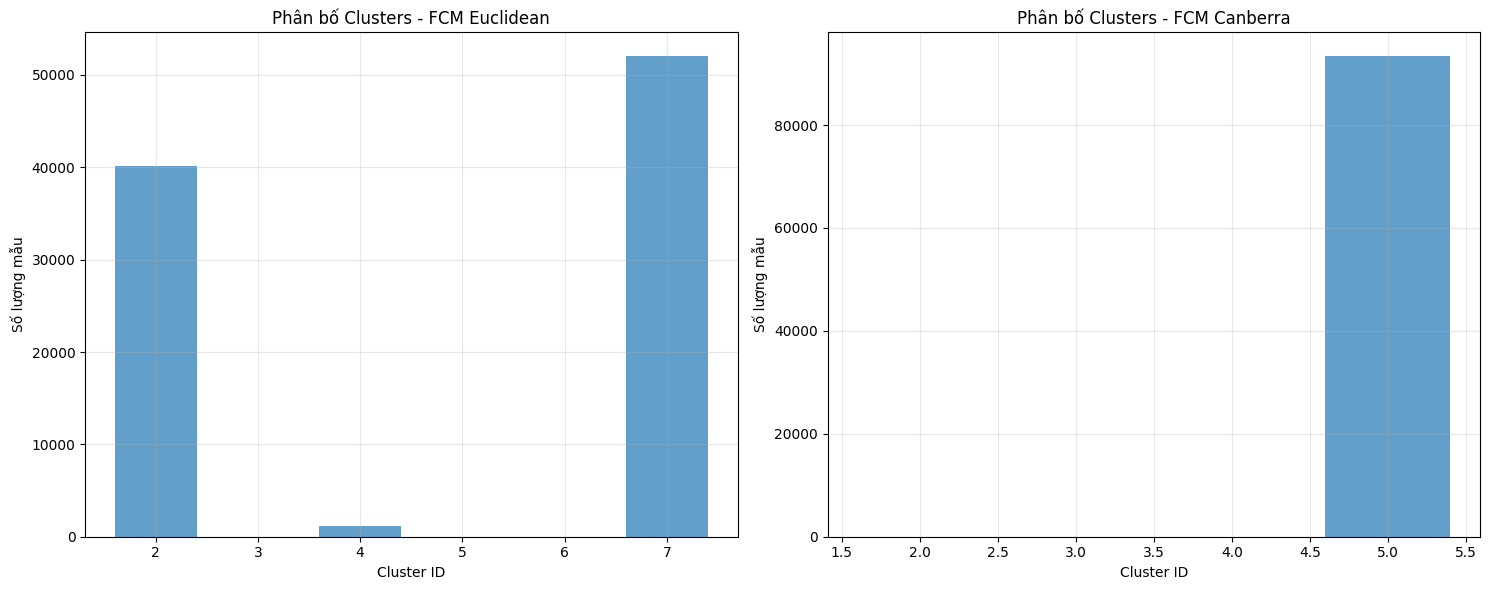

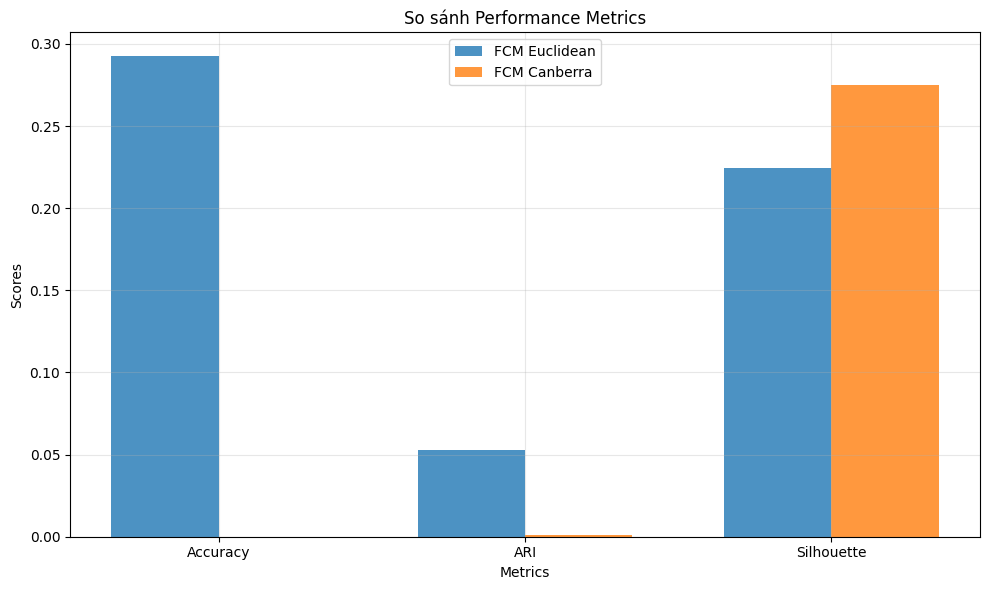

In [11]:
# Cell 8: Phân tích chi tiết
import matplotlib.pyplot as plt
import seaborn as sns

# So sánh phân bố clusters
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (name, result) in enumerate(results.items()):
    predicted = result['predicted_clusters']
    unique, counts = np.unique(predicted, return_counts=True)
    
    axes[i].bar(unique, counts, alpha=0.7)
    axes[i].set_title(f'Phân bố Clusters - {name}')
    axes[i].set_xlabel('Cluster ID')
    axes[i].set_ylabel('Số lượng mẫu')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# So sánh performance metrics
metrics_for_plot = ['accuracy', 'adjusted_rand_index', 'silhouette_score']
euc_values = [results['FCM Euclidean'][m] for m in metrics_for_plot]
can_values = [results['FCM Canberra'][m] for m in metrics_for_plot]

x = np.arange(len(metrics_for_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, euc_values, width, label='FCM Euclidean', alpha=0.8)
ax.bar(x + width/2, can_values, width, label='FCM Canberra', alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('So sánh Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(['Accuracy', 'ARI', 'Silhouette'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

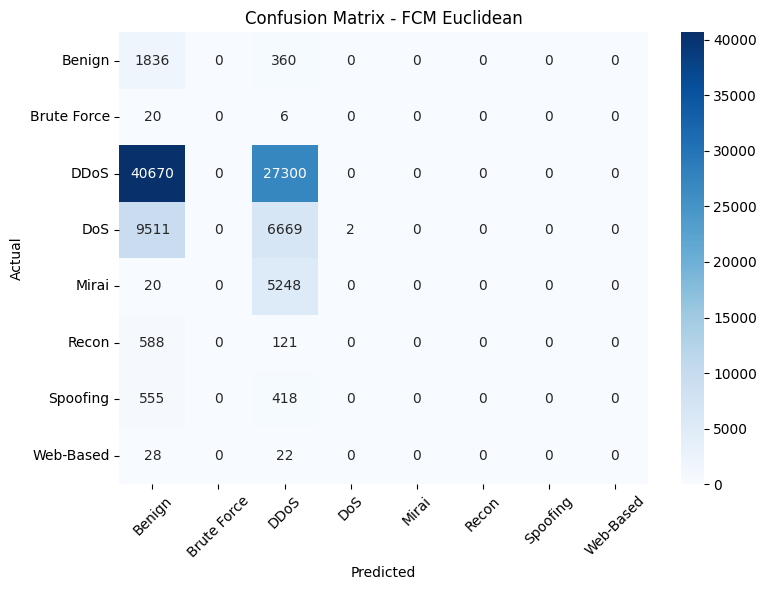

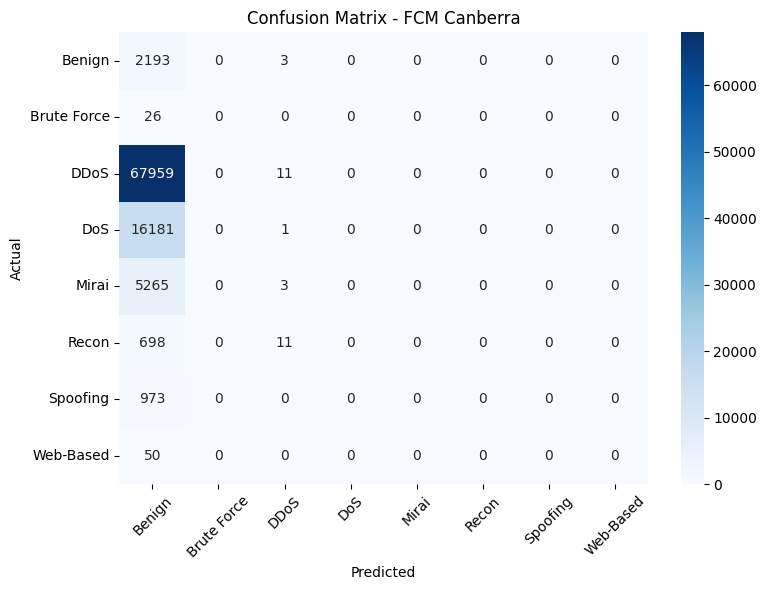

In [12]:
# Cell 9: Confusion Matrix cho cả 2 mô hình
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title, label_encoder):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Tạo confusion matrix cho cả 2 mô hình với optimal mapping
def create_optimal_mapping(predicted_clusters, true_labels_encoded):
    n_clusters = len(np.unique(predicted_clusters))
    n_classes = len(np.unique(true_labels_encoded))
    
    cost_matrix = np.zeros((n_clusters, n_classes))
    for i in range(n_clusters):
        for j in range(n_classes):
            cost_matrix[i, j] = -np.sum((predicted_clusters == i) & (true_labels_encoded == j))
    
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    mapped_predictions = np.zeros_like(predicted_clusters)
    for cluster_idx, class_idx in zip(row_indices, col_indices):
        mapped_predictions[predicted_clusters == cluster_idx] = class_idx
    
    return mapped_predictions

# Plot confusion matrices
for name, result in results.items():
    mapped_pred = create_optimal_mapping(
        result['predicted_clusters'], 
        result['true_labels_encoded']
    )
    
    plot_confusion_matrix(
        result['true_labels_encoded'], 
        mapped_pred,
        f'Confusion Matrix - {name}',
        fcm_euclidean.label_encoder  # cùng encoder cho cả 2
    )

In [13]:
# Cell 10: Tóm tắt và kết luận
print("="*80)
print("TÓM TẮT & KẾT LUẬN")
print("="*80)

best_accuracy = max(results['FCM Euclidean']['accuracy'], results['FCM Canberra']['accuracy'])
best_ari = max(results['FCM Euclidean']['adjusted_rand_index'], results['FCM Canberra']['adjusted_rand_index'])
best_silhouette = max(results['FCM Euclidean']['silhouette_score'], results['FCM Canberra']['silhouette_score'])

print(f"🏆 Accuracy cao nhất: {best_accuracy:.4f}")
if results['FCM Euclidean']['accuracy'] > results['FCM Canberra']['accuracy']:
    print("   → FCM Euclidean thắng về Accuracy")
else:
    print("   → FCM Canberra thắng về Accuracy")

print(f"🏆 ARI cao nhất: {best_ari:.4f}")
if results['FCM Euclidean']['adjusted_rand_index'] > results['FCM Canberra']['adjusted_rand_index']:
    print("   → FCM Euclidean thắng về ARI")
else:
    print("   → FCM Canberra thắng về ARI")

print(f"🏆 Silhouette cao nhất: {best_silhouette:.4f}")
if results['FCM Euclidean']['silhouette_score'] > results['FCM Canberra']['silhouette_score']:
    print("   → FCM Euclidean thắng về Silhouette")
else:
    print("   → FCM Canberra thắng về Silhouette")

print(f"\n⏱️ Thời gian training:")
print(f"   FCM Euclidean: {results['FCM Euclidean']['training_time']:.2f}s")
print(f"   FCM Canberra: {results['FCM Canberra']['training_time']:.2f}s")

print(f"\n⏱️ Thời gian prediction:")
print(f"   FCM Euclidean: {results['FCM Euclidean']['prediction_time']:.4f}s")
print(f"   FCM Canberra: {results['FCM Canberra']['prediction_time']:.4f}s")

print("\n📊 Nhận xét:")
print("- FCM Canberra có thể hoạt động tốt hơn với dữ liệu có nhiều outliers")
print("- FCM Euclidean thường ổn định hơn và được sử dụng rộng rãi")
print("- Thời gian training có thể khác nhau tùy thuộc vào cài đặt tham số")
print("="*80)

TÓM TẮT & KẾT LUẬN
🏆 Accuracy cao nhất: 0.2924
   → FCM Euclidean thắng về Accuracy
🏆 ARI cao nhất: 0.0527
   → FCM Euclidean thắng về ARI
🏆 Silhouette cao nhất: 0.2750
   → FCM Canberra thắng về Silhouette

⏱️ Thời gian training:
   FCM Euclidean: 2.96s
   FCM Canberra: 35.08s

⏱️ Thời gian prediction:
   FCM Euclidean: 0.1296s
   FCM Canberra: 0.2289s

📊 Nhận xét:
- FCM Canberra có thể hoạt động tốt hơn với dữ liệu có nhiều outliers
- FCM Euclidean thường ổn định hơn và được sử dụng rộng rãi
- Thời gian training có thể khác nhau tùy thuộc vào cài đặt tham số


In [ ]:
# Cell bổ sung: Đánh giá trên tập train để so sánh
print("="*60)
print("ĐÁNH GIÁ TRÊN TẬP TRAIN (SO SÁNH VỚI TẬP TEST)")
print("="*60)

comparator = FCMComparator()

models = {
    'FCM Euclidean': fcm_euclidean,
    'FCM Canberra': fcm_canberra
}

# Đánh giá trên tập train
results_train = comparator.compare_models(models, X_train, y_train)

# So sánh với kết quả trên tập test (giả sử đã có results từ trước)
print("\n" + "="*80)
print("SO SÁNH KẾT QUẢ TRAIN VS TEST")
print("="*80)

for model_name in models.keys():
    print(f"\n📊 {model_name}")
    print("-"*40)
    print(f"{'Metric':<25} {'Train':<15} {'Test':<15} {'Chênh lệch':<15}")
    print("-"*70)
    
    metrics = ['accuracy', 'adjusted_rand_index', 'silhouette_score']
    metric_names = ['Accuracy', 'ARI', 'Silhouette']
    
    for metric, name in zip(metrics, metric_names):
        train_val = results_train[model_name][metric]
        test_val = results[model_name][metric]
        diff = test_val - train_val
        print(f"{name:<25} {train_val:<15.4f} {test_val:<15.4f} {diff:<15.4f}")

ĐÁNH GIÁ TRÊN TẬP TRAIN (SO SÁNH VỚI TẬP TEST)

=== ĐÁNH GIÁ FCM Euclidean ===
